In [1]:
import numpy as np
from scipy.ndimage.interpolation import rotate as rotscipy
from skimage.transform import rotate
%matplotlib inline
import tensorflow as tf
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from skimage.transform import resize

(2, 24, 24)


C:\Users\Florian Chlan\Anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
C:\Users\Florian Chlan\Anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


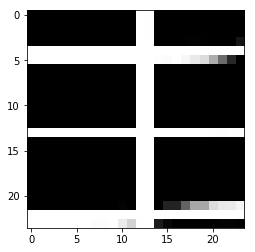

In [2]:
image_filename1 = "../data/training/groundtruth/satImage_060.png"
image_filename2 = "../data/training/groundtruth/satImage_043.png"
TARGET_SIZE = 24
original_img1 = mpimg.imread(image_filename1)
resized_img1 = resize(original_img1, (TARGET_SIZE, TARGET_SIZE))
original_img2 = mpimg.imread(image_filename2)
resized_img2 = resize(original_img2, (TARGET_SIZE, TARGET_SIZE))

resized_img = np.stack([resized_img1, resized_img2], axis=0)
print(resized_img.shape)
plt.imshow(resized_img[0,...], cmap='gray')

In [3]:
def corrupt(data, nu, type='salt_and_pepper'):
    """
    Corrupts the data for inputing into the de-noising autoencoder

    Args:
        data: numpy array of size (num_points, 1, img_size, img_size)
        nu: corruption level
    Returns:
        numpy array of size (num_points, 1, img_size, img_size)
    """
    if type == 'salt_and_pepper':
        img_max = np.ones(data.shape, dtype=bool)
        tmp = np.copy(data)
        img_max[data <= 0.5] = False
        img_min = np.logical_not(img_max)
        idx = np.random.choice(a = [True, False], size=data.shape, p=[nu, 1-nu])
        tmp[np.logical_and(img_max, idx)] = 0
        tmp[np.logical_and(img_min, idx)] = 1
    elif type == 'random_neighbourhood':

        def get_neighbourhood(img, i, j):
            startPosX = i - 1
            startPosY = j - 1
            endPosX = i + 2
            endPosY = j + 2
            centerX = 1
            centerY = 1
            if i >= img.shape[0]:
                endPosX = i + 1
            if j >= img.shape[1]:
                endPosY = j + 1
            if i - 1 < 0:
                startPosX = i
                centerX = 0
            if j - 1 < 0:
                startPosY = j
                centerY = 0

            return img[startPosX:endPosX, startPosY:endPosY], (centerX, centerY)

        def randomly_flip_8_neighbourhood(data, i, j, minval, maxval, neighbour_flip_prob):
            neighbours, centerPos = get_neighbourhood(data, i, j)

            # Choose a random mask of the 8 neighbours to flip
            mask = np.random.choice([True, False], size=neighbours.shape,
                                    p=(neighbour_flip_prob, 1 - neighbour_flip_prob))
            # Certainly flip the center position
            mask[centerPos] = True

            # Depending on the center pixel we set the random neighbourhood to the min or max intensity
            replace_val = minval if neighbours[centerPos] >= 0.5 else maxval
            replace_arr = np.full(shape=neighbours.shape, fill_value=replace_val)
            neighbours[mask] = replace_arr[mask]

        RANDOMIZATIONS_NEEDED = 2
        FLIP_BASE_CHANCE = 0.5
        FLIP_8NEIGHBOURHOOD_CHANCE = 0.8
        NEIGHBOUR_FLIP_PROB_BACKGROUND = 0.025
        NEIGHBOUR_FLIP_PROB_ROAD = 0.9
        FLIP_ROAD_BACK_THRESHOLD = 0.2

        tmp = np.copy(data)
        minval = tmp.min()
        maxval = tmp.max()

        assert tmp.shape[1] == tmp.shape[2] # Assume square images
        image_width = tmp.shape[1]
        num_patches = tmp.shape[0]
        # Sample random image indices (separately for the i- and j-dimensions)
        flips_per_image= int(image_width**2 * nu)
        random_indices = np.random.randint(0, image_width, (num_patches, flips_per_image, 2))

        # Sample all the random numbers beforehand to speedup things
        flip_probabilities = np.random.random(size=(num_patches, flips_per_image, RANDOMIZATIONS_NEEDED))

        for idxpatch in range(num_patches):

            for idxcount, indices in enumerate(random_indices[idxpatch,...]):
                i, j = indices
                if flip_probabilities[idxpatch, idxcount, 0] < FLIP_BASE_CHANCE: # Apply flip only with base chance of 50 %

                    if flip_probabilities[idxpatch, idxcount, 1] < FLIP_8NEIGHBOURHOOD_CHANCE:
                        neighbour_flip_prob = NEIGHBOUR_FLIP_PROB_ROAD if tmp[idxpatch,i,j] >= FLIP_ROAD_BACK_THRESHOLD else NEIGHBOUR_FLIP_PROB_BACKGROUND
                        # Else we also flip the neighbourhood.
                        # With 50 % chance we flip either the 8- or 4-neighbourhood
                        randomly_flip_8_neighbourhood(tmp[idxpatch,...], i, j, minval, maxval, neighbour_flip_prob)
    return tmp

In [4]:
saltnpepper_img = corrupt(resized_img, 0.05, 'salt_and_pepper')
randomneighbour_img = corrupt(resized_img, 0.05, 'random_neighbourhood')



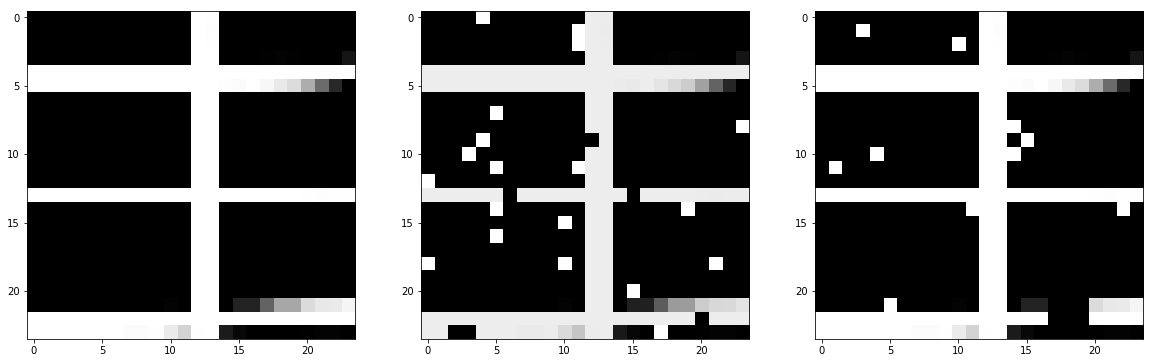

In [5]:
fig, ax = plt.subplots(ncols=3, figsize=(20, 10))
ax[0].imshow(resized_img[0,...], cmap='gray')
ax[1].imshow(saltnpepper_img[0,...], cmap='gray')
ax[2].imshow(randomneighbour_img[0,...], cmap='gray')